In [803]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import glob
from scipy.signal import butter, lfilter, freqz
from sklearn.decomposition import FastICA, PCA
from sklearn.lda import LDA
from scipy.stats import kurtosis, skew, stats
import pickle
%matplotlib inline

In [804]:
def get_filtered_data(dfile):
    data_tbl = pd.read_csv(dfile)
    events_tbl = pd.read_csv(dfile[:-8]+'events.csv')
    fdata= data_tbl.copy()
    fevents= events_tbl.copy()
    #get rid of pesky subject id that is repeated for N time points
    fdata.drop('id',axis=1,inplace=True) 
    fevents.drop('id',axis=1,inplace=True) 
    #low pass filter
    fs = 500 #Hz
    lowcut = 2 #Hz
    highcut = 8 #Hz
    for k in fdata.keys():
        fdata[k] = butter_bandpass_filter(fdata[k], lowcut, highcut, fs, order=4)
    return (fdata,fevents)

#low band pass filter all channels
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = .5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low,high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b,a = butter_bandpass(lowcut, highcut, fs, order=order)
    y=lfilter(b, a, data)
    return y

def index_event_beg_end(i_beg,i_end,series,event_name, data_for_event):
    index = 0
    while True:
        index_arr = n.where(data_for_event[index:] == 1)[0]
        if len(index_arr) == 0: break
        index+= index_arr[0]
        #ibeg is index of first 1, iend is index of last 1
        i_beg[series][event_name].append( index )
        i_end[series][event_name].append( index+149 )
        #set index to iend+1, so at a 0
        index+= 150 #width of 1's in event data
        
def ensemble_sum(ievent, buckets,fdata):
    for i in ievent: #4 buckets x 50 tpts x 32 channels
#         print i,buckets[0,:,:].shape,data_tbl.values.copy()[i-25:i+25,:].shape
#         print data_tbl.values.copy()[i-25:i+25,0]
        buckets[0,:,:]=buckets[0,:,:] + fdata.values.copy()[i-25:i+25,:]
        buckets[1,:,:]=buckets[1,:,:] + fdata.values.copy()[i+25:i+75,:]
        buckets[2,:,:]=buckets[2,:,:] + fdata.values.copy()[i+75:i+125,:]
        buckets[3,:,:]=buckets[3,:,:] + fdata.values.copy()[i+125:i+175,:]
        
def get_features(bucket):
# feat[extra] = take std dev over some N pts > 30 then compute delta std / delta t
#     feat[extra]= sum_channels_over_all_series_for_same_event_type
#power spectrum of noise, first 2 dominant frequencies? -->need sample more than 50 time points
    feat=n.zeros(10)
    feat[0]= n.median(bucket)
    feat[1]= bucket.mean()
    feat[2]= bucket.min()
    feat[3]= bucket.max()
    feat[4]= n.std(bucket)
    feat[5]= skew(bucket)
    feat[6]= kurtosis(bucket)
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(n.arange(len(bucket)),bucket)
    feat[7]= slope
    feat[8]= r_value
    feat[9]= n.absolute(bucket).sum()
    return feat

In [805]:
def target_features_for_series(dfile,i_beg, verbose=None):
    '''returns: Target feature vector array for dfile series'''
    #get series data
    (data_tbl,events_tbl)= get_filtered_data(dfile)
    series= dfile[-16:-9]
    #feature vector array
    N_features= 10
    shape= (N_features,4*events_tbl.keys().shape[0]) #n features X 4 buckets*6 target events
    target_features= n.zeros(shape)
    target_event_type= n.zeros(4*events_tbl.keys().shape[0]).astype(int)-1
    #arr to store data: 4 buckets x 50 time pts x 32 channels x 6 events
    shape= (4,50,data_tbl.keys().shape[0],events_tbl.keys().shape[0]) 
    buckets= n.zeros(shape)
    #for each event, take average of all trials in this series
    for e,event in enumerate(events_tbl.keys()):
#         print "series,event,i_beg= ",series,event,i_beg[series][event]
        #add up all trials in the series
        ensemble_sum(i_beg[series][event], buckets[:,:,:,e],data_tbl)
        #divide by N trials so sum becomes average
        buckets[:,:,:,e]= buckets[:,:,:,e]/len(i_beg[series][event])   
    #average channels for each bucket and output feature vectors 
    cnt=0
    for e,event in enumerate(events_tbl.keys()):
        signal= n.mean(buckets[:,:,:,e],axis=2)
        for b in range(4):
            target_features[:,cnt]= get_features(signal[b,:])
            target_event_type[cnt]= e+1 #0 = non target (noise) events, 1-6 = target events
            cnt+=1
    if verbose is None: return (target_event_type,target_features)
    return (target_event_type,target_features,buckets,signal) #otherwise

def TEST_target_features_for_series(dfile,i_beg):
    (event_types,features,buckets,signal)= target_features_for_series(dfile,i_beg)
    fig,axis=plt.subplots(3,2)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    ax=axis.flatten()
    for e,event in enumerate(events_tbl.keys()):
        ax[e].plot(buckets[1,:,:,e])
    fig,axis=plt.subplots(2,2)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    ax=axis.flatten()
    for b in range(4):
        ax[b].plot(signal[b,:])
    for i in range(event_types.shape[0]): 
        print "event: ",event_types[i],", features: ",features[0:3,i]

In [806]:
def add_noise_windows(a,b,cnt_arr):
    '''a,b are numpy arrays with shape = n time points X 32 channels
    cnt_arr has shape: n time points and contains the number of times each index has been summed
        so averaging can be done
    n is different for a and b'''
    if a.shape[0] == max(a.shape[0],b.shape[0]): 
        c= a.copy()
        c[:b.shape[0],:]= c[:b.shape[0],:]+b.copy()
        new_cnt= n.zeros(a.shape[0]).astype('int')+1
    else: 
        c=b.copy()
        c[:a.shape[0],:]= c[:a.shape[0],:]+a.copy()
        new_cnt= n.zeros(b.shape[0]).astype('int')+1
    new_cnt[:len(cnt_arr)]= cnt_arr+1
    return (c,new_cnt)

def every_3rd_50pt_window(window):
    '''noise has huge window with varying number of time points
    returns: every 3rd 50 time point sub-window, as many sub-windows as there are in windows'''
    ind= n.arange(window.shape[0])[::50][::3]
    nwind= len(ind)-1
    shape= (nwind,50,window.shape[1]) #n windows x 50 time points x 32 channels 
    new_window= n.zeros(shape)
    for cnt,beg in zip(range(nwind),ind[:-1]):
        new_window[cnt,:,:]= window[beg:beg+50,:]
    return new_window

def avg_noise_BothReleased_HandStart(i_beg,i_end,series, data_tbl):
    #Average trials occuring in window: BothReleased to HandStart
    #sum signal in the trials
    window_1= data_tbl.values.copy()[:i_beg[series]['HandStart'][0], :]
    cnt_arr= n.zeros(window_1.shape[0]).astype(int)+1 #increments each index when index is used in a sum
    for ileft,iright in zip(i_end[series]['BothReleased'][:-1], i_beg[series]['HandStart'][1:]):
        (window_1,cnt_arr)= add_noise_windows(window_1, data_tbl.values.copy()[ileft+1:iright, :],cnt_arr)
    #finally, divide by count to get average
    for c,chan in enumerate(data_tbl.keys()):
        window_1[:,c]= window_1[:,c]/cnt_arr
    return every_3rd_50pt_window(window_1) #n windows x 50 time points x 32 channels 

def avg_noise_HandStart_FirstDigitTouch(i_beg,i_end,series, data_tbl):
    buf= 25 #otherwise have signal at min,max indices
    (ileft,iright)= (i_end[series]['HandStart'][0],i_beg[series]['FirstDigitTouch'][0])
    window_2= data_tbl.values.copy()[ileft+1+buf:iright-buf, :]
    cnt_arr= n.zeros(window_2.shape[0]).astype(int)+1
    for ileft,iright in zip(i_end[series]['HandStart'][1:], i_beg[series]['FirstDigitTouch'][1:]):
        (window_2,cnt_arr)= add_noise_windows(window_2, data_tbl.values.copy()[ileft+1+buf:iright-buf, :],cnt_arr)
    #divide to get average
    for c,chan in enumerate(data_tbl.keys()):
        window_2[:,c]= window_2[:,c]/cnt_arr
    return every_3rd_50pt_window(window_2)

def avg_noise_HandStart_FirstDigitTouch(i_beg,i_end,series, data_tbl):
    buf= 0 #otherwise have signal at min,max indices
    (ileft,iright)= (i_end[series]['LiftOff'][0],i_beg[series]['Replace'][0])
    window_3= data_tbl.values.copy()[ileft+1+buf:iright-buf, :]
    cnt_arr= n.zeros(window_3.shape[0]).astype(int)+1
    for ileft,iright in zip(i_end[series]['LiftOff'][1:], i_beg[series]['Replace'][1:]):
        (window_3,cnt_arr)= add_noise_windows(window_3, data_tbl.values.copy()[ileft+1+buf:iright-buf, :],cnt_arr)
    #divide to get average
    for c,chan in enumerate(data_tbl.keys()):
        window_3[:,c]= window_3[:,c]/cnt_arr
    return every_3rd_50pt_window(window_3)


def noise_features_for_series(dfile,i_beg,i_end, verbose=None):
    '''returns: Noise (non target) feature vector array for dfile series'''
    #get series data
    (data_tbl,events_tbl)= get_filtered_data(dfile)
    series= dfile[-16:-9]
    #feature vector array
    N_features= 10
    shape= (N_features,3) #n features X 3 noise windows
    noise_features= n.zeros(shape)
    noise_event_type= n.zeros(3).astype(int)-1
    #for each noise event, average trials, do PCA, and get features
    noise={}
    noise['0']= avg_noise_BothReleased_HandStart(i_beg,i_end,series, data_tbl)
    noise['1']= avg_noise_HandStart_FirstDigitTouch(i_beg,i_end,series, data_tbl)
    noise['2']= avg_noise_HandStart_FirstDigitTouch(i_beg,i_end,series, data_tbl)
    for i in [0,1,2]: noise[str(i)]= n.mean(noise[str(i)],axis=2) #avg over channels
    #get features
    nwindows= 0
    for i in [0,1,2]: nwindows+= noise[str(i)].shape[0]
    noise_features= n.zeros( (N_features,nwindows) )-1
    noise_event_type= n.zeros(nwindows).astype(int)-1
    cnt=0
    for i in [0,1,2]:
        for win in range(noise[str(i)].shape[0]): #n 50 pt windows
            noise_features[:,cnt]= get_features( noise[str(i)][win,:] )
            noise_event_type[cnt]= 0 #0 is noise event
            cnt+=1
    if verbose is None: return (noise_event_type,noise_features)
    return (noise_event_type,noise_features,noise) #otherwise
     

def TEST_noise_features_for_series(dfile,i_beg,i_end):
    (noise_event_type,noise_features,noise)= noise_features_for_series(dfile,i_beg,i_end, verbose=True)
    for i in range(len(noise_event_type)): 
        print "event: ",noise_event_type[i],", features: ",noise_features[0:3,i]
    fig,axis=plt.subplots(2,3)
    ax=axis.flatten()
    for win in range(6):
        ax[win].plot(noise['0'][win,:])
    fig,axis=plt.subplots(2,3)
    ax=axis.flatten()
    for win in range(6):
        ax[win].plot(noise['1'][win,:])
    fig,axis=plt.subplots(2,3)
    ax=axis.flatten()
    for win in range(6):
        ax[win].plot(noise['2'][win,:])


In [809]:
datafiles= glob.glob('../train/subj1_series*_data.csv')
#i_beg is index of first 1, i_end is index of last 1
i_beg={}
i_end={}
(data_tbl,events_tbl)= get_filtered_data(datafiles[0]) #to get event names
#indices of target events in each series of trials
for i in range(9):
    i_beg['series'+str(i)]={}
    i_end['series'+str(i)]={}
    for event in events_tbl.keys():
        i_beg['series'+str(i)][event]=[]
        i_end['series'+str(i)][event]=[]
#feature vectors and event lables for each series of trials
vector= {}
for i in range(9):
    vector['series'+str(i)]= {}        
#fill i_beg,i_end
for dfile in datafiles:
    (data_tbl,events_tbl)= get_filtered_data(dfile)
    for event in events_tbl.keys():
        index_event_beg_end(i_beg,i_end,dfile[-16:-9],event, events_tbl[event]) 
#get features and event labels
for dfile in datafiles:
    print "loading file: %s" % (dfile)
    ##### if delete line below, crashes extracting features from subj1series2
    ##### could not figure out why
#     (data_tbl,events_tbl)= get_filtered_data(dfile)
    #####
    print 'extracting Target Features'
    (t_events,t_feats)= target_features_for_series(dfile,i_beg)
    print 'extracting Noise Features'
    (n_events,n_feats)= noise_features_for_series(dfile,i_beg,i_end)
    series= dfile[-16:-9]
    vector[series]['feats']= n.concatenate( (t_feats,n_feats),axis=1)
    vector[series]['events']= n.concatenate( (t_events,n_events),axis=1)
#save feature vectors to pickle file
tot_feats= n.concatenate((vector['series1']['feats'].copy(),\
            vector['series2']['feats'].copy(),vector['series3']['feats'].copy(),\
            vector['series4']['feats'].copy(),vector['series5']['feats'].copy(),\
            vector['series6']['feats'].copy()),axis=1)
tot_events= n.concatenate((vector['series1']['events'].copy(),\
            vector['series2']['events'].copy(),vector['series3']['events'].copy(),\
            vector['series4']['events'].copy(),vector['series5']['events'].copy(),\
            vector['series6']['events'].copy()),axis=1)
fname=datafiles[0][9:14]+"_training_features.pickle"
f= open(fname,"w")
pickle.dump((tot_feats,tot_events),f)
f.close()

loading file: ../train/subj1_series1_data.csv
extracting Target Features
extracting Noise Features
loading file: ../train/subj1_series2_data.csv
extracting Target Features
extracting Noise Features
loading file: ../train/subj1_series3_data.csv
extracting Target Features
extracting Noise Features
loading file: ../train/subj1_series4_data.csv
extracting Target Features


KeyboardInterrupt: 

In [709]:
datafiles[:6]

['../train/subj1_series1_data.csv',
 '../train/subj1_series2_data.csv',
 '../train/subj1_series3_data.csv',
 '../train/subj1_series4_data.csv',
 '../train/subj1_series5_data.csv',
 '../train/subj1_series6_data.csv']

In [731]:

my_feat.shape


(17, 470)

In [717]:
f=open(fname,"r")
(my_feat,my_event)= pickle.load(f)
f.close()
#features shape: m labels x n features
lda={}
lda['subj1']= LDA(solver='lsqr', shrinkage='auto').fit( n.swapaxes(my_feat,1,0), my_event)

In [810]:
data_tbl = pd.read_csv('../train/subj10_series1_data.csv')
events_tbl = pd.read_csv(dfile[:-8]+'events.csv')
fdata= data_tbl.copy()
fevents= events_tbl.copy()
#get rid of pesky subject id that is repeated for N time points
fdata.drop('id',axis=1,inplace=True) 

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

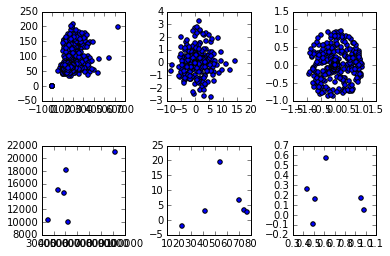

In [332]:
fig,axis=plt.subplots(2,3)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
ax[0].scatter(noise_feat_vectors[1,:],noise_feat_vectors[9,:])
ax[1].scatter(noise_feat_vectors[7,:],noise_feat_vectors[15,:])
ax[2].scatter(noise_feat_vectors[8,:],noise_feat_vectors[16,:])
ax[3].scatter(feat_vector[1,:],feat_vector[9,:])
ax[4].scatter(feat_vector[7,:],feat_vector[15,:])
ax[5].scatter(feat_vector[8,:],feat_vector[16,:])

In [363]:
#LDA training
#feature vector
shape= (N_features,noise_feat_vectors.shape[1]+feat_vector.shape[1])
comb_feat_vectors= n.zeros(shape)
comb_feat_vectors[:,:6]= feat_vector
comb_feat_vectors[:,6:]= noise_feat_vectors
#event vector
event_types= n.zeros(noise_feat_vectors.shape[1]+feat_vector.shape[1]).astype('int')
for i in range(6): event_types[i]= i+1
#train and find reduced basis features
clf= LDA(solver='lsqr', shrinkage='auto').fit( n.swapaxes(comb_feat_vectors,1,0), event_types)
#predict
# clf.n_components
# print(clf.predict_proba(test_features)

(786,) (17, 786)


In [ ]:
#using indices of where each event begins, ends extract noise between 

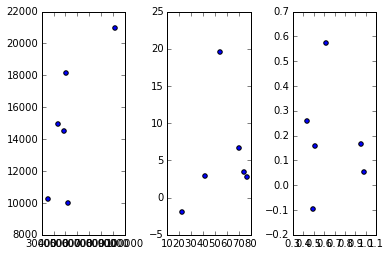

In [265]:
fig,axis=plt.subplots(1,3)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
ax[0].scatter(feat_vector[1,:],feat_vector[9,:])
ax[1].scatter(feat_vector[7,:],feat_vector[15,:])
ax[2].scatter(feat_vector[8,:],feat_vector[16,:])
# feat_vector.shape

[1]
(6, 2) (6,)


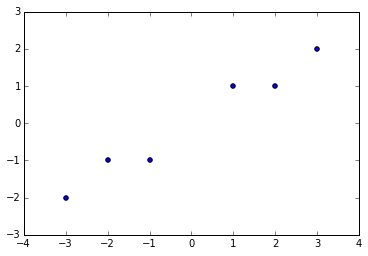

In [197]:
X = n.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = n.array([1, 1, 1, 2, 2, 2])
clf = LDA()
clf.fit(X, y)
print(clf.predict([[-0.8, -1]]))
plt.scatter(X[:,0],X[:,1])
print X.shape,y.shape

(150, 2) [[ 8.0849532   0.32845422]
 [ 7.1471629  -0.75547326]
 [ 7.51137789 -0.23807832]
 [ 6.83767561 -0.64288476]
 [ 8.15781367  0.54063935]
 [ 7.72363087  1.48232345]
 [ 7.23514662  0.3771537 ]
 [ 7.62974497  0.01667246]
 [ 6.58274132 -0.98737424]
 [ 7.36884116 -0.91362729]
 [ 8.42181434  0.67622968]
 [ 7.24739721 -0.08292417]
 [ 7.35062105 -1.0393597 ]
 [ 7.59646896 -0.77671553]
 [ 9.86936588  1.61486093]
 [ 9.18033614  2.75558626]
 [ 8.59760709  1.85442217]
 [ 7.7995682   0.60905468]
 [ 8.1000091   0.99610981]
 [ 8.04543611  1.16244332]
 [ 7.52046427 -0.156233  ]
 [ 7.60526378  1.22757267]
 [ 8.70408249  0.89959416]
 [ 6.26374139  0.46023935]
 [ 6.59191505 -0.36199821]
 [ 6.79210164 -0.93823664]
 [ 6.84048091  0.4848487 ]
 [ 7.948386    0.23871551]
 [ 8.01209273  0.11626909]
 [ 6.85589572 -0.51715236]
 [ 6.78303525 -0.72933749]
 [ 7.38668238  0.59101728]
 [ 9.16249492  1.25094169]
 [ 9.49617185  1.84989586]
 [ 7.36884116 -0.91362729]
 [ 7.9756525  -0.13519572]
 [ 8.63115466  0.43

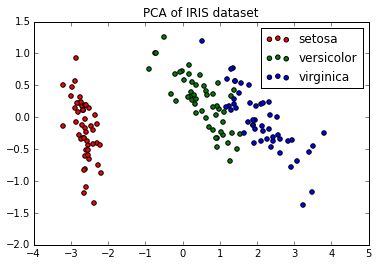

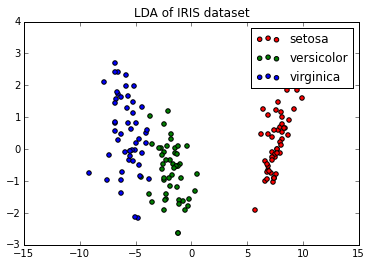

In [187]:
from sklearn import datasets


iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names
# print X.shape,y.shape,X,y
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)
print X_r2.shape,X_r2

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of IRIS dataset')

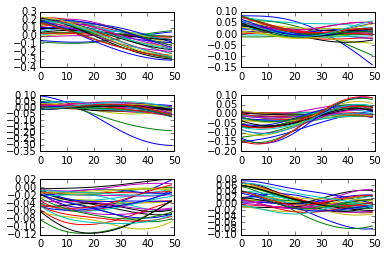

In [68]:
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for e,event in enumerate(events_tbl.keys()):
    for c,chan in enumerate(fdata_tbl.keys()): 
        ax[e].plot(buckets[e,c,2,:])

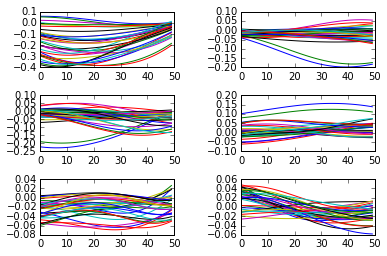

In [82]:
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for e,event in enumerate(events_tbl.keys()):
    for c,chan in enumerate(data_tbl.keys()): 
        ax[e].plot(buckets[e,c,3,:])

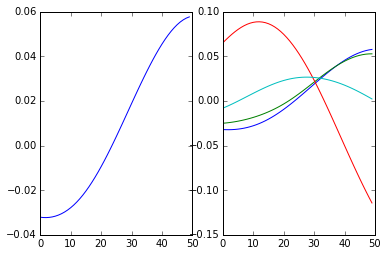

In [95]:
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(buckets[0,0,2,:])
ax[1].plot()

0.986806399844


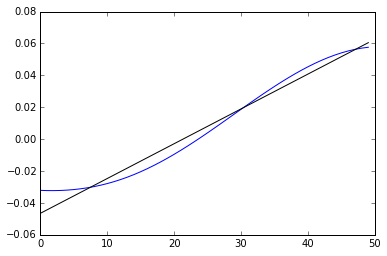

In [154]:
plt.plot(buckets[0,0,2,:])
x=n.arange(len(buckets[0,0,2,:]))
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x,buckets[0,0,2,:])
plt.plot(x,slope*x+intercept,'k-')
print r_value

integral=  3.25820050384
std=  0.0749576996093
max, min=  0.0872768506569 0.0872768506569
integral=  2.97141127501
std=  0.0666468060251
max, min=  0.118838528037 0.118838528037
integral=  5.546269047
std=  0.125088317078
max, min=  0.192280572829 0.192280572829
integral=  6.99756418681
std=  0.155845367595
max, min=  0.251137194134 0.251137194134


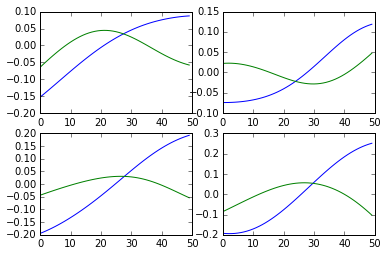

In [163]:
buck_feat= n.zeros( (4,17) )  #N buckets X N features
n.mean(buck_feat,axis=0).shape

(17,)

In [ ]:
n=.mean

In [146]:
dat= pca_arr[0,0,:,0].copy()
a=describe(dat)
# mi,ma,var,skew,kurt= (a[1][0],a[1][1],a[3],a[4],a[5])
print a


DescribeResult(nobs=50, minmax=(-0.069779300462478197, 0.030312452104789851), mean=-1.4571677198205179e-18, variance=0.0010722016996003217, skewness=-0.8534767862006325, kurtosis=-0.7286756903490681)


(-0.069779300462478197,
 0.030312452104789851,
 0.0010507576656083152,
 -0.8534767862006325,
 -0.7286756903490681)

In [138]:
a=describe(pca_arr[2,b,:,0])
print a
mi,ma,var,skew,kurt= (a[1][0],a[1][1],a[3],a[4],a[5])
print "min=",mi,'max=',ma,'stand=',stand**2,'skew=',skew,'kurt=',kurt

DescribeResult(nobs=50, minmax=(-0.19423808562751263, 0.25113719413420232), mean=1.7763568394002505e-17, variance=0.024783447551802281, skewness=0.20239493434759742, kurtosis=-1.450975587727513)
min= -0.194238085628 max= 0.251137194134 stand= 0.0247834475518 skew= 0.202394934348 kurt= -1.45097558773


(array([49]),)

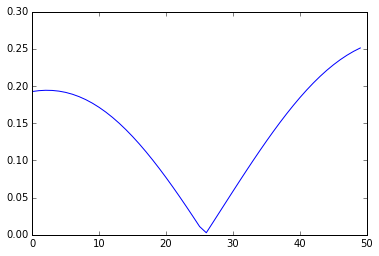

In [115]:
plt.plot(n.absolute( pca_arr[2,b,:,0] ))
n.where( n.absolute( pca_arr[2,b,:,0] ) == n.absolute( pca_arr[2,b,:,0] ).max())

In [105]:
#ICA 
shape= (events_tbl.keys().shape[0],4,50,2) #6 events, 4 buckets, 50 time pts, 2 pca components
ica_arr= n.zeros(shape)
for e,event in enumerate(events_tbl.keys()):
    for b in range(4):
        ica = FastICA(n_components=2)
        ica_arr[e,b,:,:] = ica.fit_transform( pca_arr[e,b,:,:] )  # Reconstruct signals
        A_ = ica.mixing_  # Get estimated mixing matrix




# plt.plot(demixing)
# print demixing.shape
# plt.plot(A_)

/Users/kburleigh/miniconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:117: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


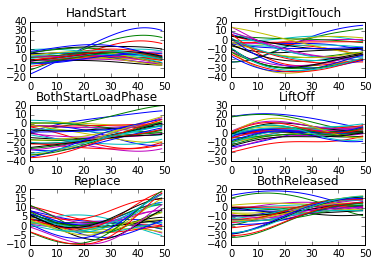

In [198]:
#covert averages dict to 2D numpy array
#6 events x 32 channels each with 50 time points
#(timepts,chan,events) ordering b/c python PCA example used this ordering
shape= (50,fdata_tbl.keys().shape[0],events_tbl.keys().shape[0],) 
avg_arr=n.zeros(shape)
#plot and store in avg_arr
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for ev_cnt,event in enumerate(events_tbl.keys()):
    ax[ev_cnt].set_title(event)
    for ch_cnt,chan in enumerate(fdata_tbl.keys()):
        ax[ev_cnt].plot(averages[chan][event])
        avg_arr[:,ch_cnt,ev_cnt]= averages[chan][event]

In [87]:
test.shape

(50,)

[  9.67735765e-01   2.93576041e-02   2.40506998e-03   4.82440491e-04
   1.70752682e-05   1.49458351e-06   3.94438893e-07   7.62628456e-08
   5.75038352e-08   1.75774962e-08   3.17869591e-09   1.20157752e-09
   1.64042994e-10   1.40420639e-10   7.26605557e-11   3.12399621e-11
   1.68668141e-11   9.10359932e-12   2.18862143e-12   1.85764439e-12
   6.22974625e-13   2.89893670e-13   8.18216733e-14   2.62583553e-14
   1.86795193e-14   1.14668190e-14   6.84091964e-15   2.95026799e-15
   8.85619734e-16   3.89157319e-16   3.01037877e-17   2.19481667e-17]


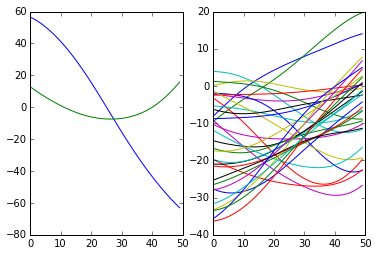

In [199]:
#PCA on numpy array
test= avg_arr.copy()[:,:,2]

pca = PCA(n_components=test.shape[1])
K= pca.fit_transform(test)
keep= n.where(pca.explained_variance_ratio_ >= 0.01)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(-K)
ax[1].plot(test)
print pca.explained_variance_ratio_

3.2684965844964609e-13

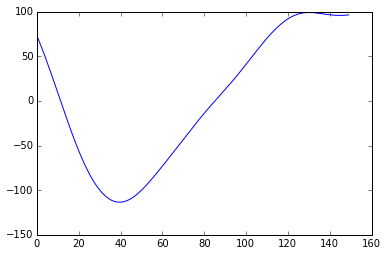

In [174]:
plt.plot(n.sum(K,axis=1))
n.sum(K)

(50, 2)


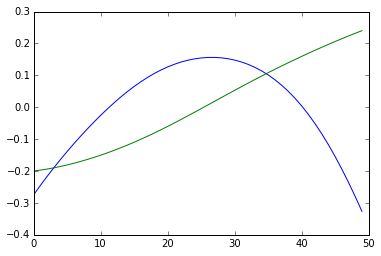

In [200]:
#ICA on numpy array
ica = FastICA(n_components=K.shape[1])
demixing = ica.fit_transform(K)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(demixing)
print demixing.shape
# plt.plot(A_)

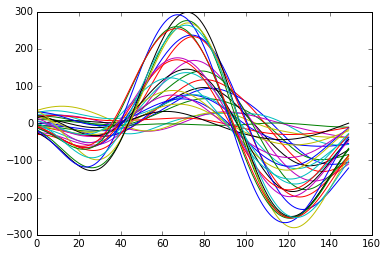

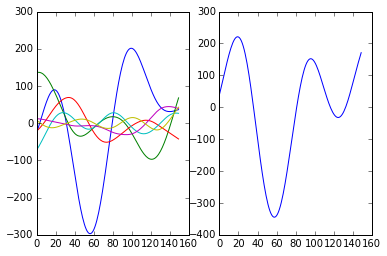

In [144]:
def ensemble_avg_1st(chan_data, event):
    index=0
    index_arr = n.where(event[index:] == 1)[0]
    index+= index_arr[0]
    #         print event[index-1],event[index],'    ', event[index+149],event[index+150]
    return chan_data.values[index:index+150]

def ensemble_avg_noise(chan_data, event):
    index=0
    index_arr = n.where(event[index:] == 1)[0]
    index+= index_arr[0]
    #         print event[index-1],event[index],'    ', event[index+149],event[index+150]
    return chan_data.values[index-300:index-150]


shape=(150,fdata_tbl.keys().shape[0])
ex = n.zeros(shape)
noise= n.zeros(shape)
event= 'HandStart'
for cnt,chan in enumerate(fdata_tbl.keys()): 
    ex[:,cnt]= ensemble_avg_1st(fdata_tbl[chan], events_tbl[event])
    noise[:,cnt]= ensemble_avg_noise(fdata_tbl[chan], events_tbl[event])
    plt.plot(ex[:,cnt])
    

pca = PCA(n_components=noise.shape[1])
K= pca.fit_transform(noise)
keep= n.where(pca.explained_variance_ratio_ >= 0.005)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(K)
ax[1].plot(n.sum(K,axis=1))


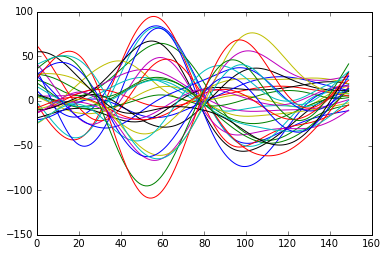

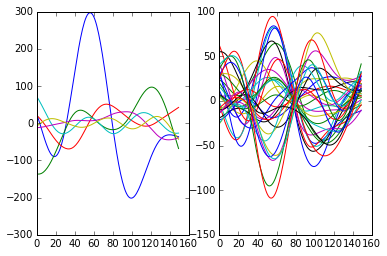

In [126]:
plt.plot(noise)
pca = PCA(n_components=ex.shape[1])
K= pca.fit_transform(noise)
keep= n.where(pca.explained_variance_ratio_ >= 0.005)[0]
K= K[:,keep]
fig,axis=plt.subplots(1,2)
ax=axis.flatten()
ax[0].plot(-K)
ax[1].plot(noise)

In [42]:
#ICA on PCA components
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(S_)
plt.plot(A_)
# We can `prove` that the ICA model applies by reverting the unmixing.
assert n.allclose(X, n.dot(S_, A_.T) + ica.mean_)


(150, 32)

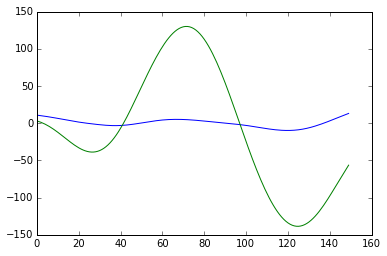

In [137]:
plt.plot(n.average(noise,axis=1))
plt.plot(n.average(ex,axis=1))

event=  HandStart
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan=  Pz
chan=  P4
chan=  P8
chan=  PO9
chan=  O1
chan=  Oz
chan=  O2
chan=  PO10
event=  FirstDigitTouch
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan=  Pz
chan=  P4
chan=  P8
chan=  PO9
chan=  O1
chan=  Oz
chan=  O2
chan=  PO10
event=  BothStartLoadPhase
chan=  Fp1
chan=  Fp2
chan=  F7
chan=  F3
chan=  Fz
chan=  F4
chan=  F8
chan=  FC5
chan=  FC1
chan=  FC2
chan=  FC6
chan=  T7
chan=  C3
chan=  Cz
chan=  C4
chan=  T8
chan=  TP9
chan=  CP5
chan=  CP1
chan=  CP2
chan=  CP6
chan=  TP10
chan=  P7
chan=  P3
chan= 

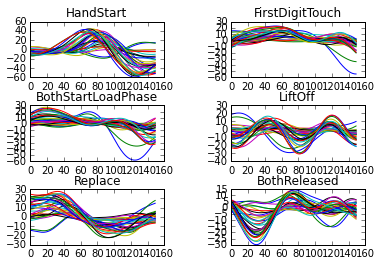

In [14]:
fig,axis=plt.subplots(3,2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ax=axis.flatten()
for cnt,event in enumerate(events_tbl.keys()):
    print "event= ",event
    ax[cnt].set_title(event)
    for chan in fdata_tbl.keys():
        print "chan= ",chan
        ax[cnt].plot(averages[chan][event])


In [39]:
pca = PCA(n_components=3)
type(X)
pca = PCA(n_components=3)
H = pca.fit_transform(X)


numpy.ndarray

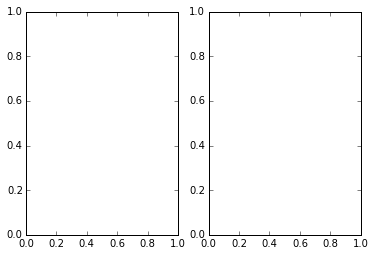

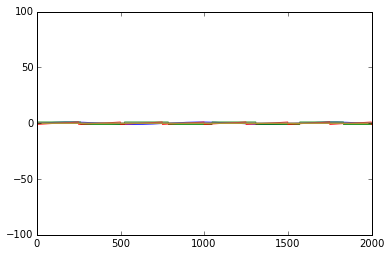

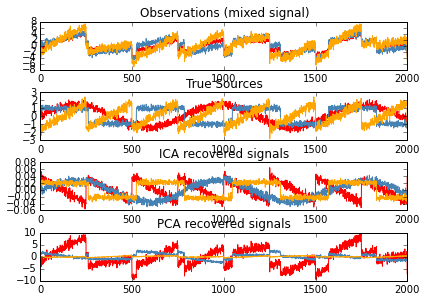

In [34]:
from sklearn.decomposition import FastICA, PCA
from scipy import signal
###############################################################################
# Generate sample data
n.random.seed(0)
n_samples = 2000
time = n.linspace(0, 8, n_samples)

s1 = n.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = n.sign(n.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * n.pi * time)  # Signal 3: saw tooth signal
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)

S = n.c_[s1, s2, s3]
S += 0.2 * n.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = n.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = n.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(S_)
plt.plot(A_)
# We can `prove` that the ICA model applies by reverting the unmixing.
assert n.allclose(X, n.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

In [33]:
H.shape

(2000, 3)

In [32]:
A_.shape,S_.shape,S.shape

((3, 3), (2000, 3), (2000, 3))